# CutMix 또는 Mixup 비교실험 하기

## 라이브러리 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

In [2]:
# GPU확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 불러오기
[stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)    
120종의 개 이미지가 있다.   
20,580개의 이미지 중 12,000개를 훈련용으로 8,580개는 테스트용으로 사용


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

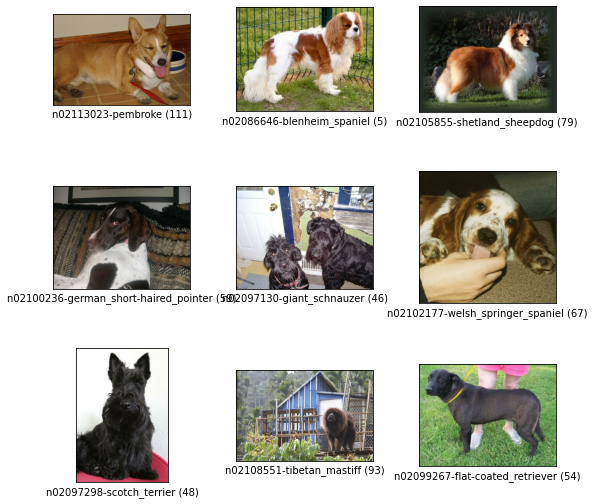

In [4]:
# 데이터 확인
tfds.show_examples(ds_train, ds_info)
plt.show()

# 1. Augmentation을 적용한 데이터셋 만들기


## CutMix
### CutMix 를 위한 이미지를 자르는 박스 설정

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # 이미지 자르는 것을 더욱 중심을 중점으로 하기 위해 센터를 50~175로 제한함.
    # get center of box
    x = tf.cast(tf.random.uniform([], 50, image_size_x-50), tf.int32)
    y = tf.cast(tf.random.uniform([], 50, image_size_y-50), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

![image](https://github.com/JeJuBOO/Aiffel_Nodes/assets/71332005/f7d1364b-f640-44f8-be9a-5d4c25fc2092)   
이와 같은 이미지 때문에 바운딩박스의 센터를 이동.

### 이미지 두개를 위의 바운딩박스의 안과 밖을 채워주는 함수

In [6]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

### 두개의 이미지를 섞어 사용하기 때문에 두개의 이미지의 라벨도 알맞게 설정해주어야 한다.

In [7]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = int((image_size_x*image_size_y) * 0.9) # 중심에 강아지가 있을 확률이 높으니 전체이미지에서 90%만 중요
    
# #     이미지에서 잘려 들어간 이미지가 전체이미지를 차지하는 비율이 50%미만일때 잘려들어간 이미지의 중요도를 낮춘다.
#     ratio = mixed_area/total_area
#     if ratio < 0.5:
#         ratio = ratio*0.8
#     ratio = tf.cast(ratio, tf.float32)
        
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

### CutMix

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Mixup


In [9]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [10]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 데이터셋을 가공하기 위한 메인 함수

In [11]:
# 기본적인 데이터 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 데이터 증강 augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image) # 랜덤 좌우 플립
    image = tf.image.random_brightness(image, max_delta=0.2) # [-0.2, 0.2] 만큼 이미지 밝기(픽셀값) 조정
    image = tf.clip_by_value(image, 0, 1) # 0~1를 넘어가는 이미지들을 0과 1로 조정
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2 # 병렬 데이터셋으로
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [12]:
num_classes = ds_info.features["label"].num_classes
batch_size = 16
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                             with_aug=False)

ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size,
                                          with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                             with_aug=True,
                                             with_cutmix=True)

ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size=batch_size, 
                                            with_aug=True, 
                                            with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

del ds_train

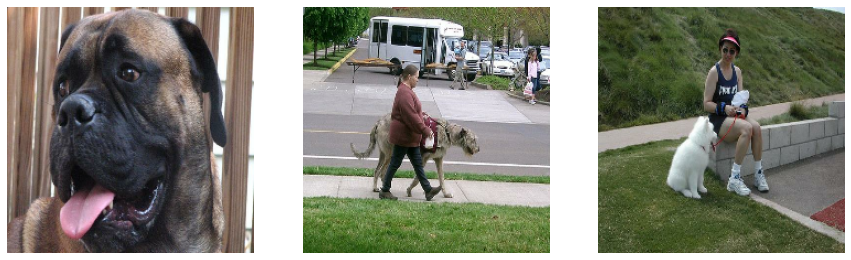

In [13]:
plt.figure(figsize=(15, 5))

for images,labels in ds_train_no_aug.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

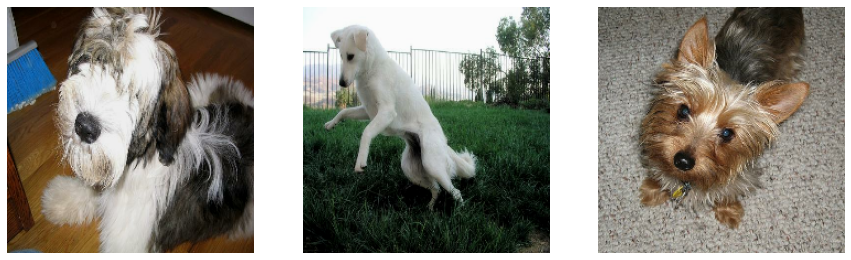

In [14]:
plt.figure(figsize=(15, 5))

for images,labels in ds_train_aug.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

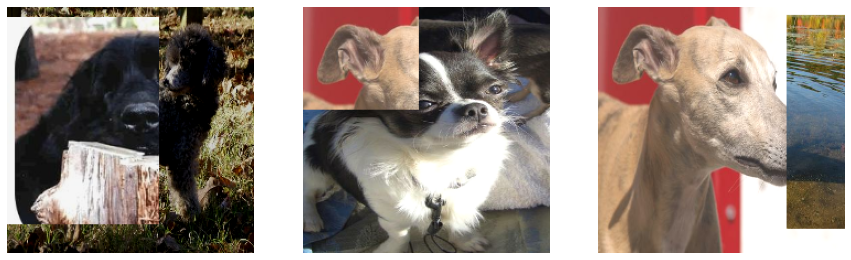

In [15]:
plt.figure(figsize=(15, 5))

for images,labels in ds_train_cutmix.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

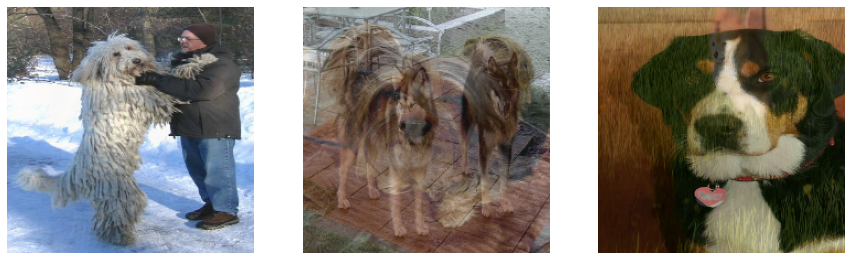

In [16]:
plt.figure(figsize=(15, 5))

for images,labels in ds_train_mixup.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(images[i])
        plt.axis("off")
    break

# 2. 모델 만들기

In [17]:
# imagenet으로 훈련한 ResNet 50에서 마지막 FC층을 우리의 데이터 클래스 수로 설정
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [18]:
# qugmentation으로 학습할 모델 추가
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
# qugmentation으로 학습할 모델 추가
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


## 모델 학습

In [23]:
EPOCH = 20
batch_size = 16
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 206ms/step - loss: 2.1809 - accuracy: 0.4543 - val_loss: 3.5084 - val_accuracy: 0.1847
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.6880 - accuracy: 0.8117 - val_loss: 1.1075 - val_accuracy: 0.6753
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 0.2124 - accuracy: 0.9556 - val_loss: 0.9211 - val_accuracy: 0.7312
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0661 - accuracy: 0.9935 - val_loss: 0.9257 - val_accuracy: 0.7318
Epoch 5/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0287 - accuracy: 0.9984 - val_loss: 0.9359 - val_accuracy: 0.7369
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0165 - accuracy: 0.9995 - val_loss: 0.9443 - val_accuracy: 0.7353
Epoch 7/20
750/750 [==============================] - 169s 225ms/step - loss: 0.0139 - accuracy: 0.9992 - val_loss: 0.9452 -

In [24]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 2.2888 - accuracy: 0.4261 - val_loss: 3.0090 - val_accuracy: 0.2733
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9568 - accuracy: 0.7243 - val_loss: 1.1859 - val_accuracy: 0.6616
Epoch 3/20
750/750 [==============================] - 153s 205ms/step - loss: 0.4946 - accuracy: 0.8658 - val_loss: 1.0358 - val_accuracy: 0.7038
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2642 - accuracy: 0.9363 - val_loss: 1.0448 - val_accuracy: 0.7132
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1393 - accuracy: 0.9753 - val_loss: 0.9932 - val_accuracy: 0.7201
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0849 - accuracy: 0.9866 - val_loss: 1.0398 - val_accuracy: 0.7181
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0509 - accuracy: 0.9944 - val_loss: 1.0279 -

In [25]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # Cut 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 207ms/step - loss: 3.8618 - accuracy: 0.2025 - val_loss: 3.3675 - val_accuracy: 0.2060
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 3.0510 - accuracy: 0.3988 - val_loss: 1.6543 - val_accuracy: 0.5524
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 2.7622 - accuracy: 0.4879 - val_loss: 1.4853 - val_accuracy: 0.5954
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5671 - accuracy: 0.5504 - val_loss: 1.3052 - val_accuracy: 0.6397
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 2.4472 - accuracy: 0.5877 - val_loss: 1.1605 - val_accuracy: 0.6685
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 2.3103 - accuracy: 0.6298 - val_loss: 1.1372 - val_accuracy: 0.6925
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2275 - accuracy: 0.6568 - val_loss: 1.5517 -

In [26]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # Cut 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 207ms/step - loss: 3.7636 - accuracy: 0.2305 - val_loss: 3.7032 - val_accuracy: 0.1535
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 2.9335 - accuracy: 0.4487 - val_loss: 1.6296 - val_accuracy: 0.5484
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6816 - accuracy: 0.5410 - val_loss: 1.4971 - val_accuracy: 0.5862
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.5139 - accuracy: 0.6077 - val_loss: 1.2797 - val_accuracy: 0.6405
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 2.4039 - accuracy: 0.6499 - val_loss: 1.3585 - val_accuracy: 0.6216
Epoch 6/20
750/750 [==============================] - 155s 206ms/step - loss: 2.3055 - accuracy: 0.6853 - val_loss: 1.2448 - val_accuracy: 0.6556
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2032 - accuracy: 0.7182 - val_loss: 1.1721 -

## 결과 시각화

### 각 모델의 train loss와 validation loss 보기

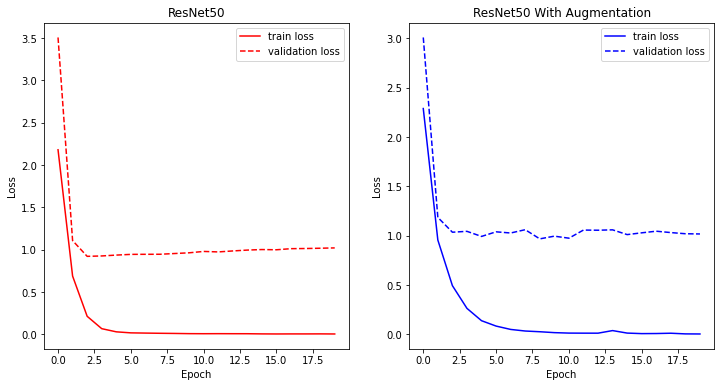

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_no_aug.history['loss'], 'r')
ax1.plot(history_resnet50_no_aug.history['val_loss'], '--r')
ax1.set_title('ResNet50')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper right')

ax2.plot(history_resnet50_aug.history['loss'], 'b')
ax2.plot(history_resnet50_aug.history['val_loss'], '--b')
ax2.set_title('ResNet50 With Augmentation')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='upper right')


plt.show()

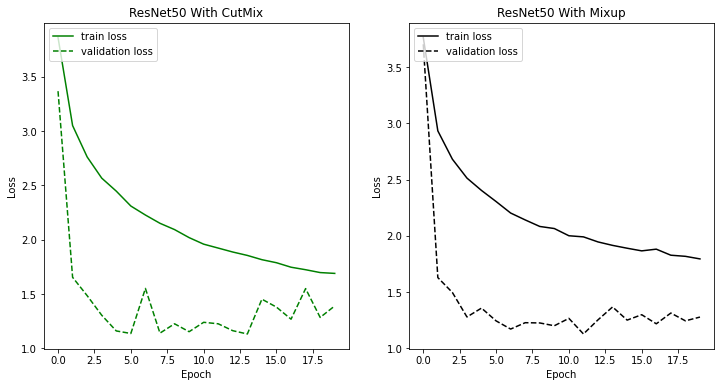

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_cutmix.history['loss'], 'g')
ax1.plot(history_resnet50_cutmix.history['val_loss'], '--g')
ax1.set_title('ResNet50 With CutMix')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['train loss', 'validation loss'], loc='upper left')

ax2.plot(history_resnet50_mixup.history['loss'], 'k')
ax2.plot(history_resnet50_mixup.history['val_loss'], '--k')
ax2.set_title('ResNet50 With Mixup')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train loss', 'validation loss'], loc='upper left')

plt.show()

validation loss는 바로 줄어드는 반면 augmentation으로 섞인 이미지가 추가되어 train loss가 빠르게 줄어들지 않습니다.   
아래에 정확도 또한 CutMix와 Mixup이 낮아지는 것은 주어진 데이터에 대해 완전히 학습이 되지 않았기에 더욱 많은 학습을 해야한다.

### 4가지 모델의 학습 결과 확인.

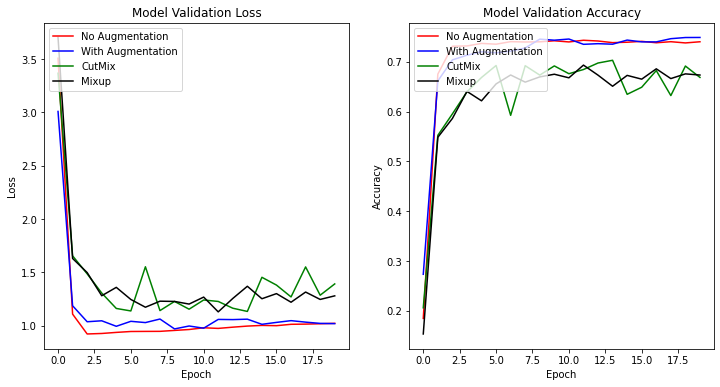

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50_no_aug.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_title('Model Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')

ax2.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_title('Model Validation Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'Mixup'], loc='upper left')

plt.show()

이미 학습된 모델을 쓰기 때문에 빠르게 정확도가 올라가는 것을 볼 수 있다. cutmix나 mixup은 두개의 이미지를 합쳐서 학습한다. 이로 인해 라벨이 원핫에서 두개의 이미지의 확률로 존재하기에 정확도가 낮아진 것으로 보인다.

## 회고
노드의 내용과 이전에 사용했던 내용을 복붙을 하며 진행했습니다. 과정에서 제대로 작동되지 않은 부분이 mix2label 을 사용할때 인수가 안들어간 것을 디버깅을 진행했고, 바로 20epoch씩 학습을 진행하니.. 시간이 모델 하나당 약 1시간을 써서 4시간 남짓한 시간동안 기다리며 코드를 자세히 보고 제목과 주석을 첨가하고 다른 공부를 했습니다. 따라서 LMS와 colab을 동시에 이용해야 겠다는 생각을 했고, 더욱 효율적으로 시간을 쓰기 위해 생각을 해야할 것 같았습니다.

진행하면서 두가지 이미지가 섞이고 라벨링또한 변경되면서, 노이즈들이 섞이고 이를 학습을 하기 위해서는 오랜시간이 필요해 보인다. 그래서 더욱 효율적으로 학습을 어떻게 시킬까 하다가 강아지가 대부분 가운데에 작게 크게 센터를 중심으로 있기에 이미지 자르기를 쫌더 가운데로 모이도록 해본다.

위 결과는 CutMix를 변경하기 전 epoch20번을 진행한 결과이고, 아래의 결과는 변경 후 epoch10번을 한 결과이다.
비교가 힘들지만. epoch 10번 20번으로 결과를 보는것이 어려운 것 같다. augmentation한 결과에서 기존보다 일반적이 특징을 학습해야하기 위한 시간이 필요하다고 생각하여 colab에서 돌리는 중이다.

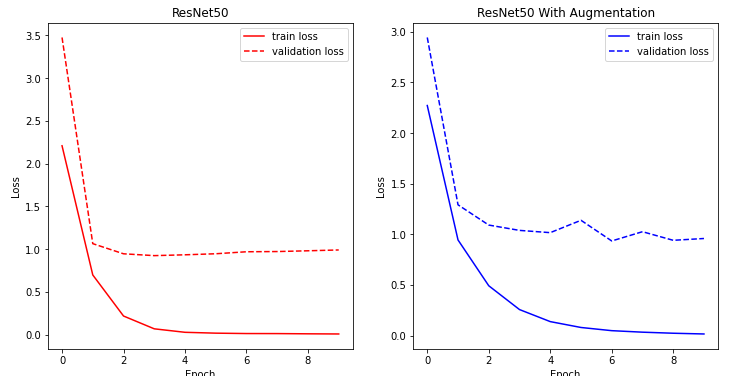

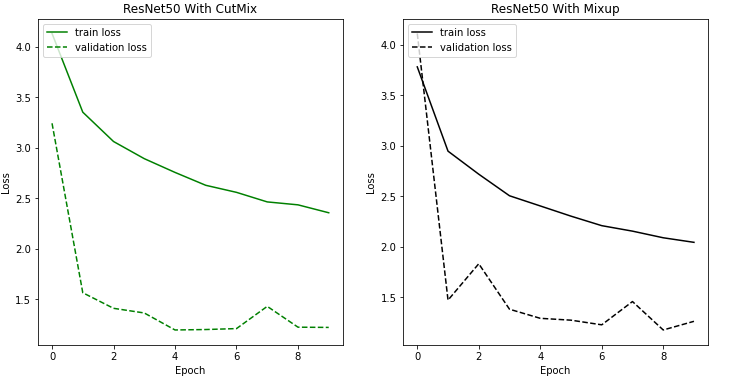
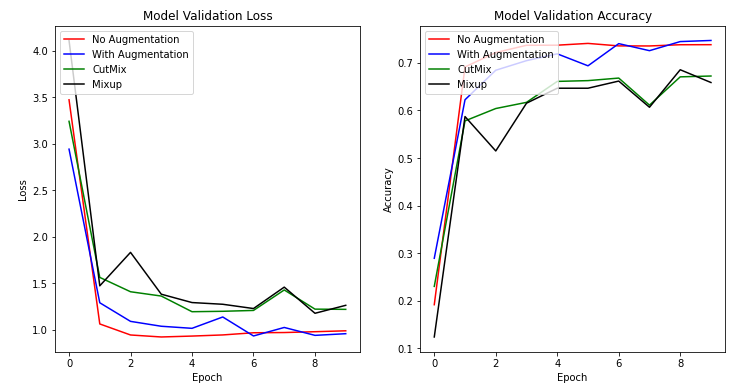

비교를 위해 변경한 CutMix를 20epoch 진행했지만 확실한 성능의 변화를 볼수는 없었다.
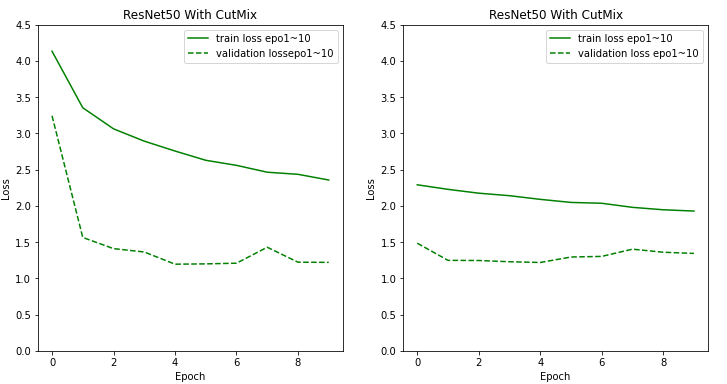